In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle as pkl
import ast
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

For this project, we are going to relocate learning rate, epochs, batch size, momentum etc. arguments to the train function and define the attributes right before training. 

In [15]:
# NETORK CLASS
class NN2( ):
    def __init__(self, dims, learning_rate, batch_size = 50, epochs = 100, momentum_rate = None, patience = None, dropout_rate = None):
        """
        Args:
            in_dim (int): input dimension
            h_dim (int): dimension of the hidden layer
            out_dim (int): output dimension
            lr (float): learning rate
            epochs (int): epochs to train the model
            lambd (float, optional): parameter of the L2 regularization term. Defaults to 0.
            activation (int, optional): 1 corresponds to tanh activations on both layers, 
                                        2 corresponds to ReLU in the first layer and sigmoid in the output layer. Defaults to 1.
            batch_size (int, optional): Batch size for mini-batch gradient descent. Defaults to None.
        Returns: None
        """
        # save the hyperparameters
        self.lr = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        # store the momentum rate
        if momentum_rate != None:
            self.momentum_rate = momentum_rate
        elif momentum_rate == None:
            self.momentum_rate = None
        # store the patience
        if patience != None:
            self.patience = patience
            self.stopper = EarlyStopper(patience)
        elif patience == None:
            self.patience = None
            self.stopper = None
        # store the dropout rate
        if dropout_rate != None:
            self.dropout_rate = dropout_rate
        elif dropout_rate == None:
            self.dropout_rate = None
        
        # initailize the weights, using Glorot initialization
        self.dims = dims
        self.W = {}
        self.b = {}
        for i in range(1, len(dims)):
            self.W[f"W{i}"] = np.random.normal(0, np.sqrt( 2 / (dims[i-1] + dims[i])), (dims[i], dims[i-1])) # W1, ..., WL (L = len(dims) - 1)
            self.b[f"b{i}"] = np.zeros((dims[i], 1)) # b1, ..., bL (L = len(dims) - 1)
                    
        # store the gradients for update step
        self.grads = {} # store the gradients for W and b for layers 1...L
        
        # store the loss and accuracy at every step
        # TO BACKPROP
        self.train_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        
        # self times
        # TO TRAIN 
        self.forward_time = []
        self.backprop_time = []
        self.update_time = []
        self.train_time = []
        self.test_time = []
        self.cv_time = []
        
        # mistakes
        # TO ACCURACY
        self.train_mistakes = []
        self.test_mistakes = []
        
# UTILITY FUNCTIONS
    def reset_weights(self):
        """Used to reset the weights for each bootstrap

        Returns: None
        """
        # re-initailize the weights, using Glorot initialization
        self.W = {}
        self.b = {}
        for i in range(1, len(self.dims)):
            self.W[f"W{i}"] = np.random.normal(0, np.sqrt( 2 / (self.dims[i-1] + self.dims[i])), (self.dims[i], self.dims[i-1]))
            self.b[f"b{i}"] = np.zeros((self.dims[i], 1))
        return None
    
    def set_attributes(self, NN):
        """_summary_

        Args:
            NN (_type_): _description_

        Raises:
            ValueError: _description_

        Returns:
            _type_: _description_
        """
        # weights and biases
        self.W = NN.W
        self.b = NN.b
        # loss and accuracy
        self.train_loss = NN.train_loss
        self.test_loss = NN.test_loss
        self.train_accuracy = NN.train_accuracy
        self.test_accuracy = NN.test_accuracy
        self.val_loss = NN.val_loss
        self.val_accuracy = NN.val_accuracy
        # times
        self.forward_time = NN.forward_time
        self.backprop_time = NN.backprop_time
        self.update_time = NN.update_time
        self.train_time = NN.train_time
        self.test_time = NN.test_time
        return None
    
    def initialize_momentum(self):
        """Used to initialize the momentum terms

        Returns: None
        """
        self.V = {}
        for key in self.W.keys():
            self.V[key] = np.zeros(self.W[key].shape)
        for key in self.b.keys():
            self.V[key] = np.zeros(self.b[key].shape)
        return None
    
    def batchify(self, X, Y, batch_size):
        """Provides batch indices for batch training

        Args:
            X (ndarray): the training data, shape (D_x, m, T_x)
            Y (ndarray): the training labels, shape (D_o, m)
            batch_size (int): batch size
        """

        # get number of batches
        num_batches = X.shape[1] // batch_size
        # initialize batched X, Y
        batchindices = []
        
        I = np.random.permutation(X.shape[1])
        
        for i in range(num_batches):
            if i == num_batches - 1:
                #print(I[i*batch_size:].shape)
                batchindices.append(I[i*batch_size:])
            else:
                batchindices.append(I[i*batch_size:(i+1)*batch_size])        
        
        return batchindices, num_batches

# NONLINEARITY FUNCTIONS
    def relu(self, Z):
        """ReLU activation function

        Args:
            Z (ndarray): pre-activation data

        Returns:
            ReLU(Z): ReLU activation of Z
        """
        return np.maximum(0, Z)
    
    def relu_gradient(self, Z):
        """ReLU gradient

        Args:
            Z (ndarray): pre-activation data

        Returns:
            ReLU(Z): gradient of the ReLU activation of Z
        """
        return np.where(Z > 0, 1, 0)
    
    def softmax(self, Z):
        """Softmax activation function

        Args:
            Z (ndarray): pre-activation data (6, m)

        Returns:
            Softmax(Z): Softmax activation of Z (6, m)
        """
        return np.exp(Z) / np.sum(np.exp(Z), axis=0)
    
    def softmax_gradient(self, softmaxcache):
        """Softmax gradient

        Args:
            softmaxcache (ndarray): pre-activation data, cached, shape (6, m)

        Returns:
            SoftmaxGrad(Z): gradient of the Softmax activation of Z
        """
        dSoftmax = - softmaxcache @ softmaxcache.T # shape (6, 6)
        for i in range(dSoftmax.shape[0]):
            dSoftmax[i, i] = softmaxcache[i] * (1 - softmaxcache[i])
        return dSoftmax # shaep (6, 6)

# LOSS FUNCTIONS
    def CCEcost(self, Y, Y_pred):
        """Categorical Cross-entropy loss function

        Args:
            Y (ndarray): true labels, shape (6, m)
            Y_pred (ndarray): predicted labels, shape (6, m)

        Returns:
            cost: cross-entropy loss
        """
        return - np.sum(Y * np.log(Y_pred)) / Y_pred.shape[1]
    
    def CCEgradient(self, Y, Y_pred):
        """Categorical Cross-entropy gradient

        Args:
            Y (ndarray): true labels, shape (6, m)
            Y_pred (ndarray): predicted labels, shape (6, m)

        Returns:
            dCCE: gradient of the CCE loss
        """
        return - Y / Y_pred # shape (6, m)

# ACCURACY FUNCTION
    def accuracy(self, Y, Y_pred):
        """Copmutes the Top1,2,3 accuracies given the one-hot encoded Y

        Args:
            Y (ndarray): ground truth, shape (6, m)
            Y_pred (ndarray): prediction, shape (6, m)
        """
        # to get Top1,2,3 accuracies, we first convert Y to a 1D array of shape (1, m)
        # then, we convert most probable predictions in Y_pred into an array of shape (3, m)
        #print(Y.shape, Y)
        Y = np.argmax(Y, axis = 0, keepdims=True) # shape (1, m)a
        #print(Y.shape, Y)
        Y_pred = np.argsort(Y_pred, axis = 0)[-3:, :] # shape (3, m)
        #print(Y_pred.shape, Y_pred)
        # now, we check if the most probable prediction is in Y
        # if yes, we add 1 to the accuracy
        # if not, we add 0
        accuracy = np.zeros((3, Y.shape[1])) # shape (3, m)
        for i in range(3):
            for k in range(Y.shape[1]):
            # if Y[0, k] is in Y_pred[0:i, k], then accuracy[i, k] = 1, else = 0 
                if Y[0, k] in set(Y_pred[3-i-1:3, k]):        
                    accuracy[i, k] = 1
                
        return np.mean(accuracy, axis = 1, keepdims = True) #/ Y.shape[1] # shape (3, 1)

# REGULARIZATION FUNCTIONS
    def dropout(self, X , dropout_rate = None) :
        """Dropout regularization
        """
        if dropout_rate == None: # no dropout
            return X
        
        elif 0 <= dropout_rate <= 1: # if dropout rate is between 0 and 1
            mask = np.random.binomial(1, 1/2, (X.shape[0], X.shape[1]))
            X_masked = (X * mask)/(1 - dropout_rate)
            return X_masked
        else:
            raise ValueError("p_drop must be between 0 and 1")

# NETWORK FUNCTIONS 
    def forwardprop(self, X, predict = False, dropout_rate = None):
        """Forward propagation

        Args:
            X (ndarray): input data, shape (d, m)

        Returns:
            Y_pred (ndarray): predicted labels, shape (6, m)
        """
        
        if predict == False:
            # store the values for backpropagation
            self.cache = {} # store pre-activation and activation values for layers 2...L
            for i in range(1, len(self.dims)):
                if i == 1: # use X on the 1st layer 
                    self.cache[f"Z{i}"] = (self.W[f"W{i}"] @ X) + self.b[f"b{i}"]
                    self.cache[f"A{i}"] = self.relu(self.cache[f"Z{i}"])
                elif i == len(self.dims) - 1 : # softmax on the last layer 
                    self.cache[f"Z{i}"] = (self.W[f"W{i}"] @ self.cache[f"A{i-1}"]) + self.b[f"b{i}"]
                    self.cache[f"A{i}"] = self.softmax(self.cache[f"Z{i}"])
                elif i == 2: # dropout on the 2nd layer 
                    self.cache[f"Z{i}"] = (self.W[f"W{i}"] @ self.cache[f"A{i-1}"]) + self.b[f"b{i}"]
                    self.cache[f"A{i}"] = self.dropout(self.relu(self.cache[f"Z{i}"]), dropout_rate = self.dropout_rate)
                else: # relu on the rest of the layers
                    self.cache[f"Z{i}"] = (self.W[f"W{i}"] @ self.cache[f"A{i-1}"]) + self.b[f"b{i}"]
                    self.cache[f"A{i}"] = self.relu(self.cache[f"Z{i}"])
            return None
        
        if predict == True:
            for i in range(1, len(self.dims)):
                if i == len(self.dims) - 1 :
                    Y_pred = self.softmax((self.W[f"W{i}"] @ Y_pred) + self.b[f"b{i}"])
                elif i == 1:
                    Y_pred = self.relu((self.W[f"W{i}"] @ X) + self.b[f"b{i}"])
                else:
                    Y_pred = self.relu((self.W[f"W{i}"] @ Y_pred) + self.b[f"b{i}"])
            return Y_pred
        
    def backprop(self, X, Y, momentum_rate):
        """Backpropagation

        Args:
            X (ndarray): input data, shape (d, m)
            Y (ndarray): true labels, shape (6, m)

        Returns:
            None
        """
        if momentum_rate == None:
            # CORRECT
            # compute the gradients
            self.grads = {}
            m = X.shape[1]
            for i in range(len(self.dims) - 1, 0, -1):
                if i == len(self.dims) - 1:
                    self.grads[f"dZ{i}"] = self.cache[f"A{i}"] - Y
                    self.grads[f"dW{i}"] = (1/m) * self.grads[f"dZ{i}"] @ self.cache[f"A{i-1}"].T
                    self.grads[f"db{i}"] = np.mean(self.grads[f"dZ{i}"], axis = 1, keepdims = True)
                elif i == 1:
                    self.grads[f"dZ{i}"] = self.relu_gradient(self.cache[f"A{i}"]) * (self.W[f"W{i+1}"].T @ self.grads[f"dZ{i+1}"])
                    self.grads[f"dW{i}"] = (1/m) * self.grads[f"dZ{i}"] @ X.T / m
                    self.grads[f"db{i}"] = np.mean(self.grads[f"dZ{i}"], axis = 1, keepdims = True)
                else:
                    self.grads[f"dZ{i}"] = self.relu_gradient(self.cache[f"A{i}"]) * (self.W[f"W{i+1}"].T @ self.grads[f"dZ{i+1}"])
                    self.grads[f"dW{i}"] = (1/m) * self.grads[f"dZ{i}"] @ self.cache[f"A{i-1}"].T / m
                    self.grads[f"db{i}"] = np.mean(self.grads[f"dZ{i}"], axis = 1, keepdims = True)
                
            return None
        
        elif momentum_rate != None:
            # CORRECT 
            # compute the gradients
            self.grads = {}
            self.initialize_momentum() # store the momentum terms for W and b for layers 1...L
            m = X.shape[1]
            for i in range(len(self.dims) - 1, 0, -1):
                if i == len(self.dims) - 1:
                    self.grads[f"dZ{i}"] = self.cache[f"A{i}"] - Y
                    self.grads[f"dW{i}"] = (1/m) * self.grads[f"dZ{i}"] @ self.cache[f"A{i-1}"].T
                    self.grads[f"db{i}"] = np.mean(self.grads[f"dZ{i}"], axis = 1, keepdims = True)
                    self.V[f"W{i}"] = momentum_rate * self.V[f"W{i}"] + ( 1 - momentum_rate ) * self.grads[f"dW{i}"]
                    self.V[f"b{i}"] = momentum_rate * self.V[f"b{i}"] + ( 1 - momentum_rate ) * self.grads[f"db{i}"]
                elif i == 1:
                    self.grads[f"dZ{i}"] = self.relu_gradient(self.cache[f"A{i}"]) * (self.W[f"W{i+1}"].T @ self.grads[f"dZ{i+1}"])
                    self.grads[f"dW{i}"] = (1/m) * self.grads[f"dZ{i}"] @ X.T
                    self.grads[f"db{i}"] = np.mean(self.grads[f"dZ{i}"], axis = 1, keepdims = True) 
                    self.V[f"W{i}"] = momentum_rate * self.V[f"W{i}"] + ( 1 - momentum_rate ) * self.grads[f"dW{i}"]
                    self.V[f"b{i}"] = momentum_rate * self.V[f"b{i}"] + ( 1 - momentum_rate ) * self.grads[f"db{i}"]
                else:
                    self.grads[f"dZ{i}"] = self.relu_gradient(self.cache[f"A{i}"]) * (self.W[f"W{i+1}"].T @ self.grads[f"dZ{i+1}"])
                    self.grads[f"dW{i}"] = (1/m) * self.grads[f"dZ{i}"] @ self.cache[f"A{i-1}"].T / m
                    self.grads[f"db{i}"] = np.mean(self.grads[f"dZ{i}"], axis = 1, keepdims = True)
                    self.V[f"W{i}"] = momentum_rate * self.V[f"W{i}"] + ( 1 - momentum_rate ) * self.grads[f"dW{i}"]
                    self.V[f"b{i}"] = momentum_rate * self.V[f"b{i}"] + ( 1 - momentum_rate ) * self.grads[f"db{i}"]

            return None
        
    def update(self, momentum_rate = None):
        """Update step

        Args:
            lr (float): learning rate

        Returns:
            None
        """
        # CORRECT
        if momentum_rate == None:
            for i in range(1, len(self.dims)):
                self.W[f"W{i}"] = self.W[f"W{i}"] - self.lr * self.grads[f"dW{i}"]
                self.b[f"b{i}"] = self.b[f"b{i}"] - self.lr * self.grads[f"db{i}"]
        if momentum_rate != None:
            for i in range(1, len(self.dims)):
                self.W[f"W{i}"] = self.W[f"W{i}"] - self.lr * self.V[f"W{i}"]
                self.b[f"b{i}"] = self.b[f"b{i}"] - self.lr * self.V[f"b{i}"]
        return None
    
    def train(self, X, Y, X_val, Y_val, X_test, Y_test, reset = False):
        """Train the model
        Args:
            """

        if reset == True:
            # initialize the weights
            self.reset_weights()
                    
        # get batch indices
        batchindices, num_batches = self.batchify(X, Y, self.batch_size)
        # initialize the best validation loss
        best_val_loss = np.inf
        # initialize the best parameters
        best_params = (self.W, self.b)
        # training loop, compute the training loss and accuracy at the end of each epoch
        # and the test loss and accuracy at the end of every 10th epoch
        t = time.time()
        for e in range(self.epochs):
            for b in range(num_batches):
                # get batch
                X_batch = X[:, batchindices[b]]
                Y_batch = Y[:, batchindices[b]]
                
                # forward propagation
                self.forwardprop(X_batch)
                
                # print the loss and accuracy at the beginning of the first epoch
                if e == 0 and b == 0:
                    print("blank loss:", np.mean(self.CCEcost(Y, self.forwardprop(X, predict=True))))
                    print("blank accuracy:", self.accuracy(Y, self.forwardprop(X, predict=True)))
                
                # backpropagation
                self.backprop(X_batch, Y_batch, self.momentum_rate)
                
                # update weights
                self.update(self.momentum_rate)
            
            # compute train metrics
            Y_pred = self.forwardprop(X, predict=True)
            self.train_loss.append(np.mean(self.CCEcost(Y, Y_pred)))
            self.train_accuracy.append(self.accuracy(Y, Y_pred))
            # print train metrics
            print(f"Epoch {e+1}, Train Loss: {self.train_loss[-1]}, Train Accuracy Top1: {self.train_accuracy[-1][0]}")
            
            # compute validation metrics
            Y_pred_val = self.forwardprop(X_val, predict=True)
            self.val_loss.append(np.mean(self.CCEcost(Y_val, Y_pred_val)))
            self.val_accuracy.append(self.accuracy(Y_val, Y_pred_val))
            # print validation metrics
            print(f"Epoch {e+1}, Validation Loss: {self.val_loss[-1]}, Validation Accuracy Top1: {self.val_accuracy[-1][0]}")
            
            if self.patience != None:
                if self.val_loss[-1] < best_val_loss:
                    best_params = (self.W, self.b)
                    best_val_loss = self.val_loss[-1]
                    self.stopper.reset()
                else:
                    if self.stopper.increment_and_check(): # outputs true when no improvement in validation loss for patience epochs
                        self.W, self.b = best_params
                        print(f"Early stopping at epoch {e+1}")
                        self.stop_epoch = e+1
                        self.training_time = time.time() - t
                        print(f"Total time elapsed: {self.training_time} seconds")
                        return None
                
            if (e + 1) % 10 == 0 or e == 0:
                # compute test metrics
                Y_pred_test = self.forwardprop(X_test, predict=True)
                self.test_loss.append(np.mean(self.CCEcost(Y_test, Y_pred_test)))
                self.test_accuracy.append(self.accuracy(Y_test, Y_pred_test))
                # print test metrics
                print(f"Epoch {e+1}: train loss = {self.train_loss[-1]}, test loss = {self.test_loss[-1]}, train accuracy = {self.train_accuracy[-1]}, test accuracy = {self.test_accuracy[-1]}")
            
        self.training_time = time.time() - t
        print(f"Total time elapsed: {self.training_time} seconds")
        return None            

In [5]:
# utility functions
def train_validation_split(X, Y, split_ratio = 0.1):
    """Split the data into training and validation sets.
    Args:
        X (_type_): _description_
        Y (_type_): _description_
        split_ratio (float, optional): _description_. Defaults to 0.1.
    """
    shuffled_indices = np.random.permutation(X.shape[1])
    X_train = X[:, shuffled_indices[:int((1 - split_ratio) * X.shape[1])]]
    Y_train = Y[:, shuffled_indices[:int((1 - split_ratio) * X.shape[1])]]
    X_val = X[:, shuffled_indices[int((1 - split_ratio) * X.shape[1]):]]
    Y_val = Y[:, shuffled_indices[int((1 - split_ratio) * X.shape[1]):]]
    return X_train, Y_train, X_val, Y_val

def onehot_encode(Y):
    """One-hot encode the labels.
    Args:
        Y (ndarray): labels, shape (1, m)

    Returns:
        Y_onehot (ndarray): one-hot encoded labels, shape (6, m)
    """
    # get the number of classes and initialize the one-hot encoded matrix
    Y_onehot = np.zeros((int(np.max(Y)), Y.shape[1]))
    # one-hot encode the labels
    for i in range(Y_onehot.shape[1]):
        # Y[i] is the label of the ith sample, so we set the ith row of Y_onehot to 1
        Y_onehot[int(Y[0,i]) - 1, i] = 1
    return Y_onehot

In [6]:
# retrieve the data 
paths = {}
paths["train_x"] = r"UCI HAR Dataset\UCI HAR Dataset\train\X_train.txt"
paths["train_y"] = r'UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt'
paths["test_x"] = r'UCI HAR Dataset\UCI HAR Dataset\test\X_test.txt'
paths["test_y"] = r'UCI HAR Dataset\UCI HAR Dataset\test\y_test.txt'

# Use numpy's loadtxt function to load the data into an ndarray
data = {}
for key,  path in paths.items():
    data[key] = np.loadtxt(path)

print(data["train_x"].shape)
print(data["train_y"].shape)
print(data["test_x"].shape)
print(data["test_y"].shape)

print(np.min(data["train_y"]))

(7352, 561)
(7352,)
(2947, 561)
(2947,)
1.0


In [7]:
# Split into train, validation and test sets, and rearrange the dimension to (D_layer, batch_size)
X_train, Y_train, X_val, Y_val = train_validation_split(np.transpose(data["train_x"], (1, 0)), data["train_y"].reshape(1, -1), split_ratio = 0.1)
X_test = np.transpose(data["test_x"], (1, 0))
Y_test = data["test_y"].reshape(1, -1)

# One-hot encode the labels
Y_train = onehot_encode(Y_train)
Y_val = onehot_encode(Y_val)
Y_test = onehot_encode(Y_test)

In [12]:
# set hyperparameters
Dx = X_train.shape[0] 
Dy = 6 
lrs = [0.01, 0.001] 
dimensions = [(Dx, 300, 100, Dy), (Dx, 300, 200, Dy)] 
momentum_rates = [None, 0.99]
mini_batch_sizes = [1, 50] 

In [383]:
# create the models
models = {(lr, dims, momentum_rate, mini_batch_size):NN2(dims, lr, batch_size = mini_batch_size, momentum_rate = momentum_rate, patience = 10) for lr in lrs for dims in dimensions for momentum_rate in momentum_rates for mini_batch_size in mini_batch_sizes}

In [384]:
# TRAIN THE MODELS
for i, key in enumerate(models.keys()):
        print(f"Model {i+1} out of {len(models.keys())}")
        models[key].train(X_train, Y_train, X_val, Y_val, X_test, Y_test)
        print("\n")

[0.01, [561, 300, 100, 6], None, 1]
[0.01, [561, 300, 100, 6], None, 50]
[0.01, [561, 300, 100, 6], 0.99, 1]
[0.01, [561, 300, 100, 6], 0.99, 50]
[0.01, [561, 300, 200, 6], None, 1]
[0.01, [561, 300, 200, 6], None, 50]
[0.01, [561, 300, 200, 6], 0.99, 1]
[0.01, [561, 300, 200, 6], 0.99, 50]
[0.001, [561, 300, 100, 6], None, 1]
[0.001, [561, 300, 100, 6], None, 50]
[0.001, [561, 300, 100, 6], 0.99, 1]
[0.001, [561, 300, 100, 6], 0.99, 50]
[0.001, [561, 300, 200, 6], None, 1]
[0.001, [561, 300, 200, 6], None, 50]
[0.001, [561, 300, 200, 6], 0.99, 1]
[0.001, [561, 300, 200, 6], 0.99, 50]
Model 1 out of 16
(1,)
blank loss: 1.9370670425402179
blank accuracy: [[0.21448005]
 [0.49214027]
 [0.61124547]]
Epoch 1, Train Loss: 0.28894495731922715, Train Accuracy Top1: [0.8635127]
Epoch 1, Validation Loss: 0.3245746348085502, Validation Accuracy Top1: [0.85190217]
Epoch 1: train loss = 0.28894495731922715, test loss = 0.48430114838447735, train accuracy = [[0.8635127 ]
 [0.99501209]
 [0.99984885]]

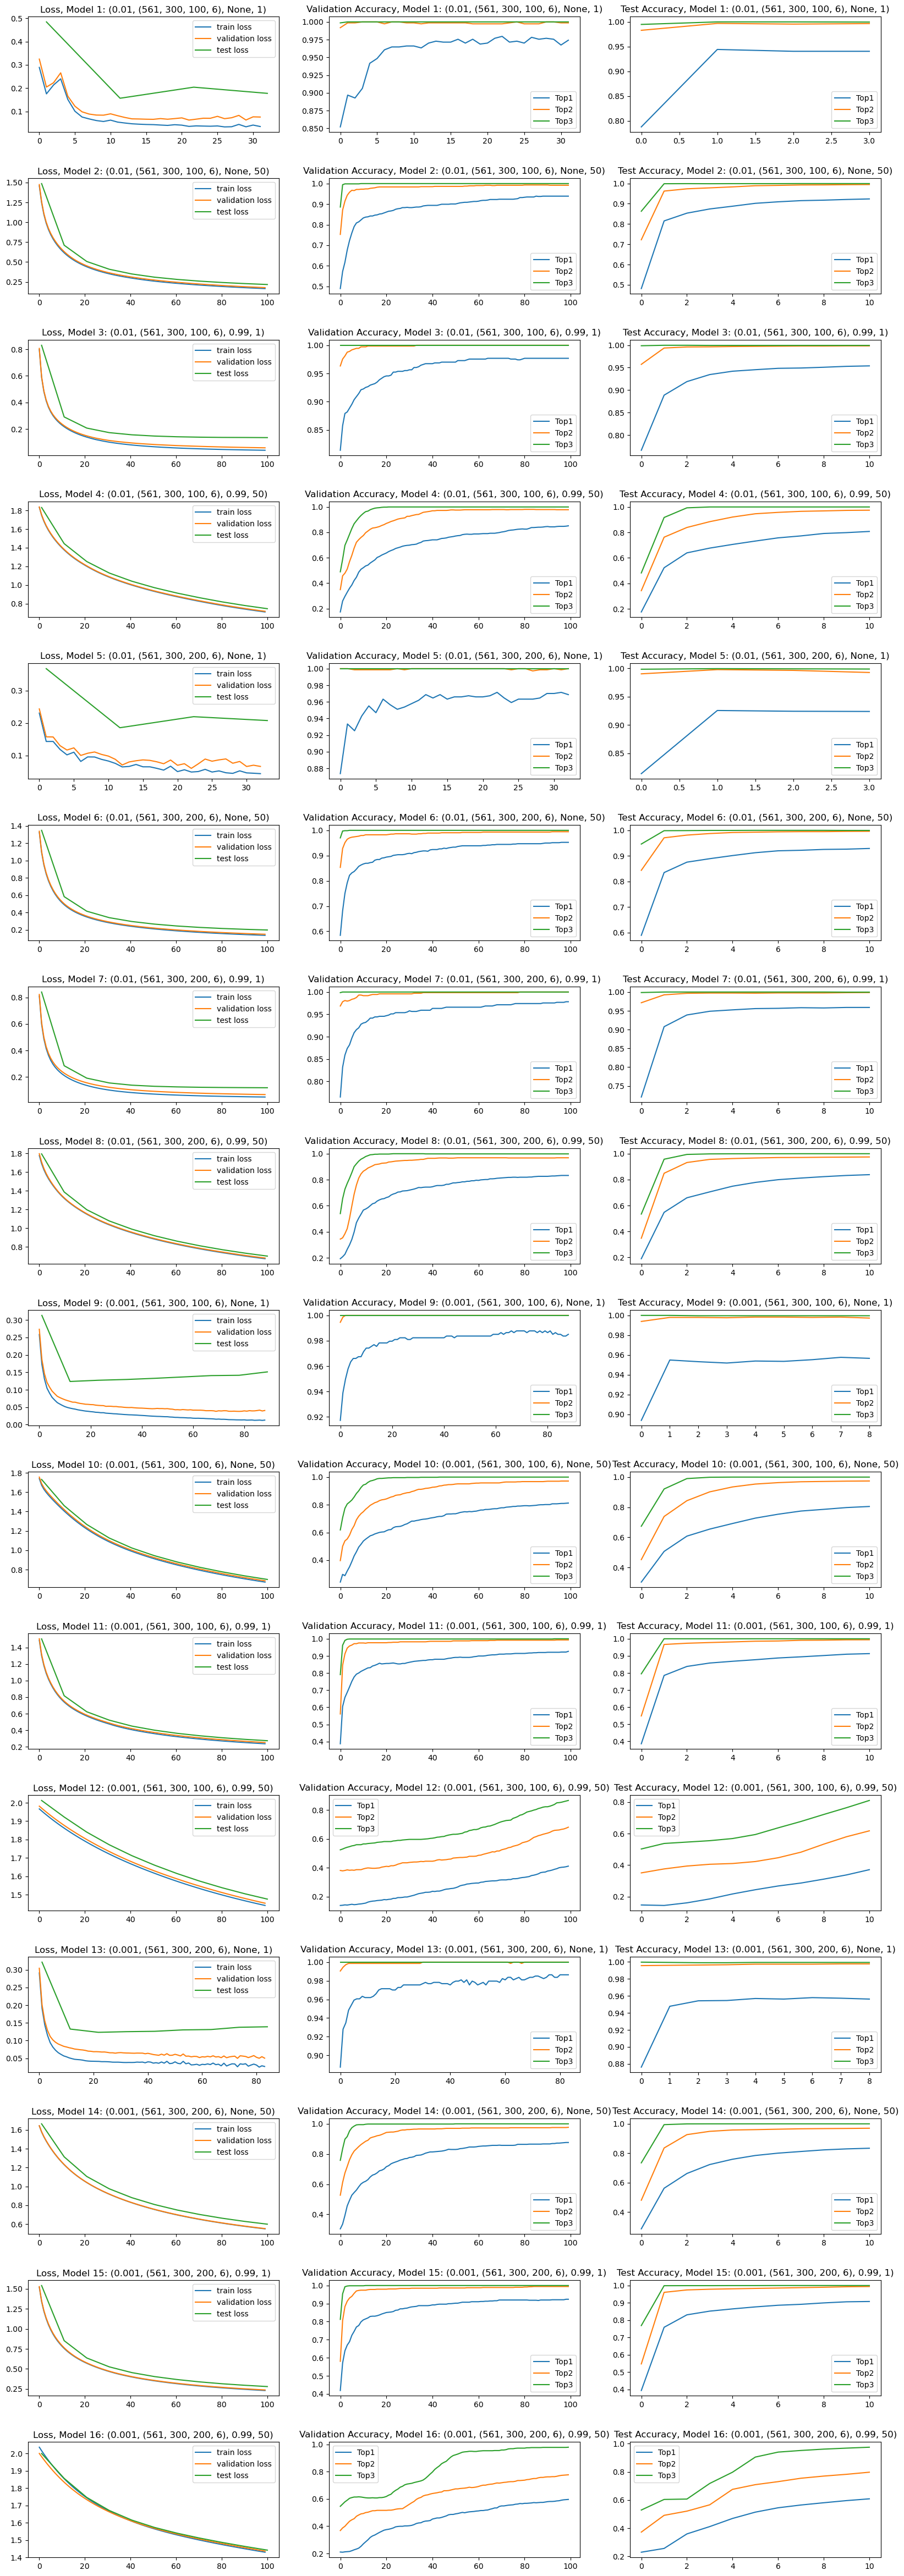

In [153]:
# plot metrics of part (a) models
ESepochs = [len(models[key].train_loss) for key in models.keys()]

# plot the train and test loss
fig, ax = plt.subplots(16, 3, figsize = (20, 60))
for i, key in enumerate(models.keys()):
    # plot the losses on the first column
    ax[i, 0].plot(range(ESepochs[i]), models[key].train_loss, label = "train loss")
    ax[i, 0].plot(range(ESepochs[i]), models[key].val_loss, label = "validation loss")
    ax[i, 0].plot(np.linspace(1, ESepochs[i], (ESepochs[i]//10) + 1), models[key].test_loss, label = "test loss")
    ax[i, 0].set_title(f"Loss, Model {i+1}: {key}")
    ax[i, 0].legend()
    # plot the validation accuracies on the second column
    ax[i, 1].plot(range(ESepochs[i]), [acc[0] for acc in models[key].val_accuracy], label = "Top1")
    ax[i, 1].plot(range(ESepochs[i]), [acc[1] for acc in models[key].val_accuracy], label = "Top2")
    ax[i, 1].plot(range(ESepochs[i]), [acc[2] for acc in models[key].val_accuracy], label = "Top3")
    ax[i, 1].set_title(f"Validation Accuracy, Model {i+1}: {key}")
    ax[i, 1].legend()
    # plot the test accuracies
    ax[i, 2].plot( [acc[0] for acc in models[key].test_accuracy], label = "Top1")
    ax[i, 2].plot( [acc[1] for acc in models[key].test_accuracy], label = "Top2")
    ax[i, 2].plot( [acc[2] for acc in models[key].test_accuracy], label = "Top3")
    ax[i, 2].set_title(f"Test Accuracy, Model {i+1}: {key}")
    ax[i, 2].legend()

plt.subplots_adjust(hspace=0.4)

Model 0: (0.01, (561, 300, 100, 6), None, 1)
Model 1: (0.01, (561, 300, 100, 6), None, 50)
Model 2: (0.01, (561, 300, 100, 6), 0.99, 1)
Model 3: (0.01, (561, 300, 100, 6), 0.99, 50)
Model 4: (0.01, (561, 300, 200, 6), None, 1)
Model 5: (0.01, (561, 300, 200, 6), None, 50)
Model 6: (0.01, (561, 300, 200, 6), 0.99, 1)
Model 7: (0.01, (561, 300, 200, 6), 0.99, 50)
Model 8: (0.001, (561, 300, 100, 6), None, 1)
Model 9: (0.001, (561, 300, 100, 6), None, 50)
Model 10: (0.001, (561, 300, 100, 6), 0.99, 1)
Model 11: (0.001, (561, 300, 100, 6), 0.99, 50)
Model 12: (0.001, (561, 300, 200, 6), None, 1)
Model 13: (0.001, (561, 300, 200, 6), None, 50)
Model 14: (0.001, (561, 300, 200, 6), 0.99, 1)
Model 15: (0.001, (561, 300, 200, 6), 0.99, 50)


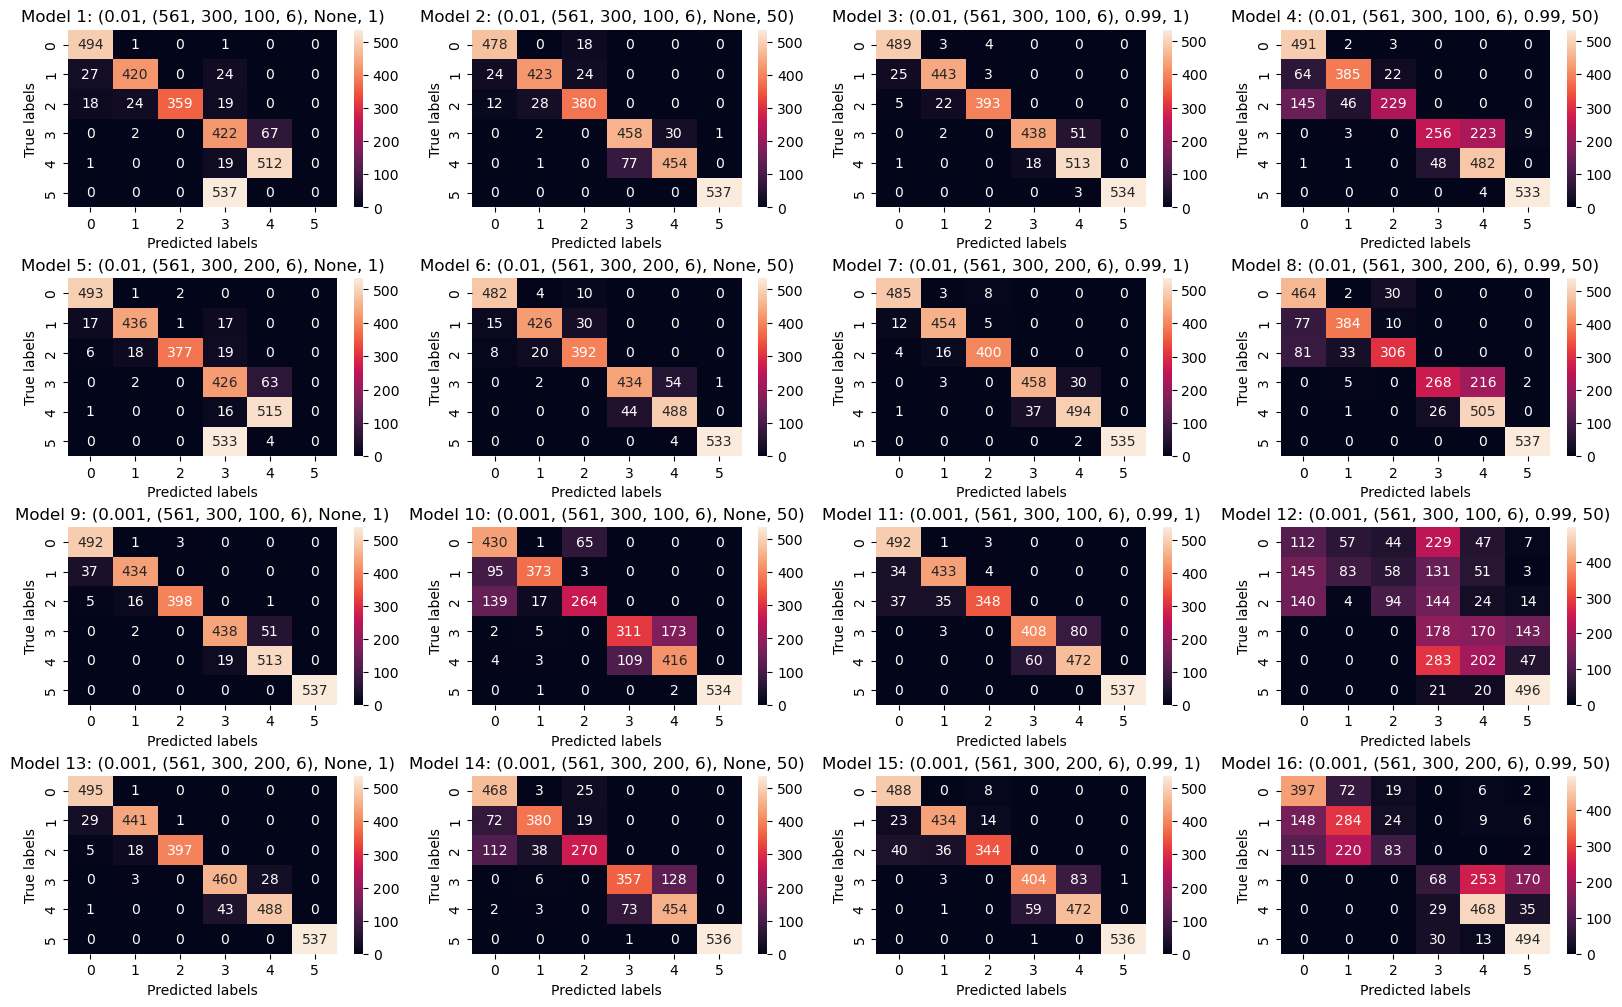

In [176]:
# generate predictions and create the confusion matrix for all models in part (a) on the test set
fig, ax = plt.subplots(4, 4, figsize = (20, 12))
for i, key in enumerate(models.keys()):
    Y_hat = models[key].forwardprop(X_test, predict=True)
    Y_hat = np.argmax(Y_hat, axis = 0, keepdims=True) 
    Y_true = np.argmax(Y_test, axis = 0, keepdims=True)
    cm = confusion_matrix(Y_true[0], Y_hat[0])
    sns.heatmap(cm, annot=True, ax = ax[(i//4), (i%4)], fmt='g')
    ax[(i//4), (i%4)].set_title(f"Model {i+1}: {key}")
    ax[(i//4), (i%4)].set_xlabel("Predicted labels")
    ax[(i//4), (i%4)].set_ylabel("True labels")
plt.subplots_adjust(hspace=0.4, wspace=0.2)

Except the 12th and 16th models, Top3 and Top2 errors asymptotically converge to 1, hence we will look at the Top1 accuracy of the rest of the models to select the best configurations.

In [102]:
# print the model accuracies
for i, key in enumerate(models.keys()):
    print(f"Model {i+1} out of {len(models.keys())}")
    print(f"Train accuracy: {models[key].train_accuracy[-1][0]}")
    print(f"Test accuracy: {models[key].test_accuracy[-1][0]}")
    print("\n")

Model 1 out of 16
Train accuracy: [0.98669891]
Test accuracy: [0.94027825]


Model 2 out of 16
Train accuracy: [0.94573761]
Test accuracy: [0.92365117]


Model 3 out of 16
Train accuracy: [0.99002418]
Test accuracy: [0.95385137]


Model 4 out of 16
Train accuracy: [0.85247884]
Test accuracy: [0.80760095]


Model 5 out of 16
Train accuracy: [0.98443168]
Test accuracy: [0.9239905]


Model 6 out of 16
Train accuracy: [0.95979444]
Test accuracy: [0.92908042]


Model 7 out of 16
Train accuracy: [0.98276904]
Test accuracy: [0.9589413]


Model 8 out of 16
Train accuracy: [0.8449214]
Test accuracy: [0.83814048]


Model 9 out of 16
Train accuracy: [0.99516324]
Test accuracy: [0.956566]


Model 10 out of 16
Train accuracy: [0.82300484]
Test accuracy: [0.804547]


Model 11 out of 16
Train accuracy: [0.92442563]
Test accuracy: [0.913132]


Model 12 out of 16
Train accuracy: [0.43500605]
Test accuracy: [0.37088565]


Model 13 out of 16
Train accuracy: [0.98957074]
Test accuracy: [0.95622667]


Mode

Models 3, 7, 9, 13 are the highest in test accuracy, and are very close. Notice that they are all online trained, and none of the mini batch models can surpass their performance. However, due to the significant change in training time between online and batch training, we will also select the best batch-trained model just to see how the difference will play out when including droput. To select among 3, 7, 9, 13, looking at the training and test accuracies tell us that model 7 has smallest gap b/w training and test accuracy, and has the most robust learning behavior. Although it would be also wise to favor lower complexity, model 3 seems to have overfitted more to the training data. To see how batch-training performs, we'll also select 6, and for a control, we'll also train model 8. 

In [62]:
# construct a dictionary with 3 models, identical in configuration to 6,7,8
dropoutmodel_configs = [(0.01, (Dx, 300, 200, Dy), 0.99, 1, 1/2), (0.01, (Dx, 300, 200, Dy), None, 50, 1/2), (0.01, (Dx, 300, 200, Dy), 0.99, 50, 1/2)]
dropout_models = {config : NN2(config[1], config[0], batch_size = config[3], momentum_rate = config[2], dropout_rate=config[4]) for config in dropoutmodel_configs}

In [63]:
# train the models 
for i, key in enumerate(dropout_models.keys()):
        print(f"Model {i+1} out of {len(dropout_models.keys())}")
        dropout_models[key].train(X_train, Y_train, X_val, Y_val, X_test, Y_test)
        print("\n")

Model 1 out of 3
(1,)
blank loss: 2.1153803483473084
blank accuracy: [[0.13301088]
 [0.23579202]
 [0.47249093]]
Epoch 1, Train Loss: 1.04516677173924, Train Accuracy Top1: [0.77373035]
Epoch 1, Validation Loss: 1.0509362044906507, Validation Accuracy Top1: [0.7513587]
Epoch 1: train loss = 1.04516677173924, test loss = 1.0749967196640682, train accuracy = [[0.77373035]
 [0.96251511]
 [0.99758162]], test accuracy = [[0.78554462]
 [0.96165592]
 [0.99558873]]
Epoch 2, Train Loss: 0.7992227403176972, Train Accuracy Top1: [0.82587666]
Epoch 2, Validation Loss: 0.8105342234869048, Validation Accuracy Top1: [0.81657609]
Epoch 3, Train Loss: 0.6630527735203574, Train Accuracy Top1: [0.856711]
Epoch 3, Validation Loss: 0.6764705119207912, Validation Accuracy Top1: [0.83967391]
Epoch 4, Train Loss: 0.5758824414329032, Train Accuracy Top1: [0.86804716]
Epoch 4, Validation Loss: 0.5901851746127025, Validation Accuracy Top1: [0.85461957]
Epoch 5, Train Loss: 0.5124814617429164, Train Accuracy Top1:

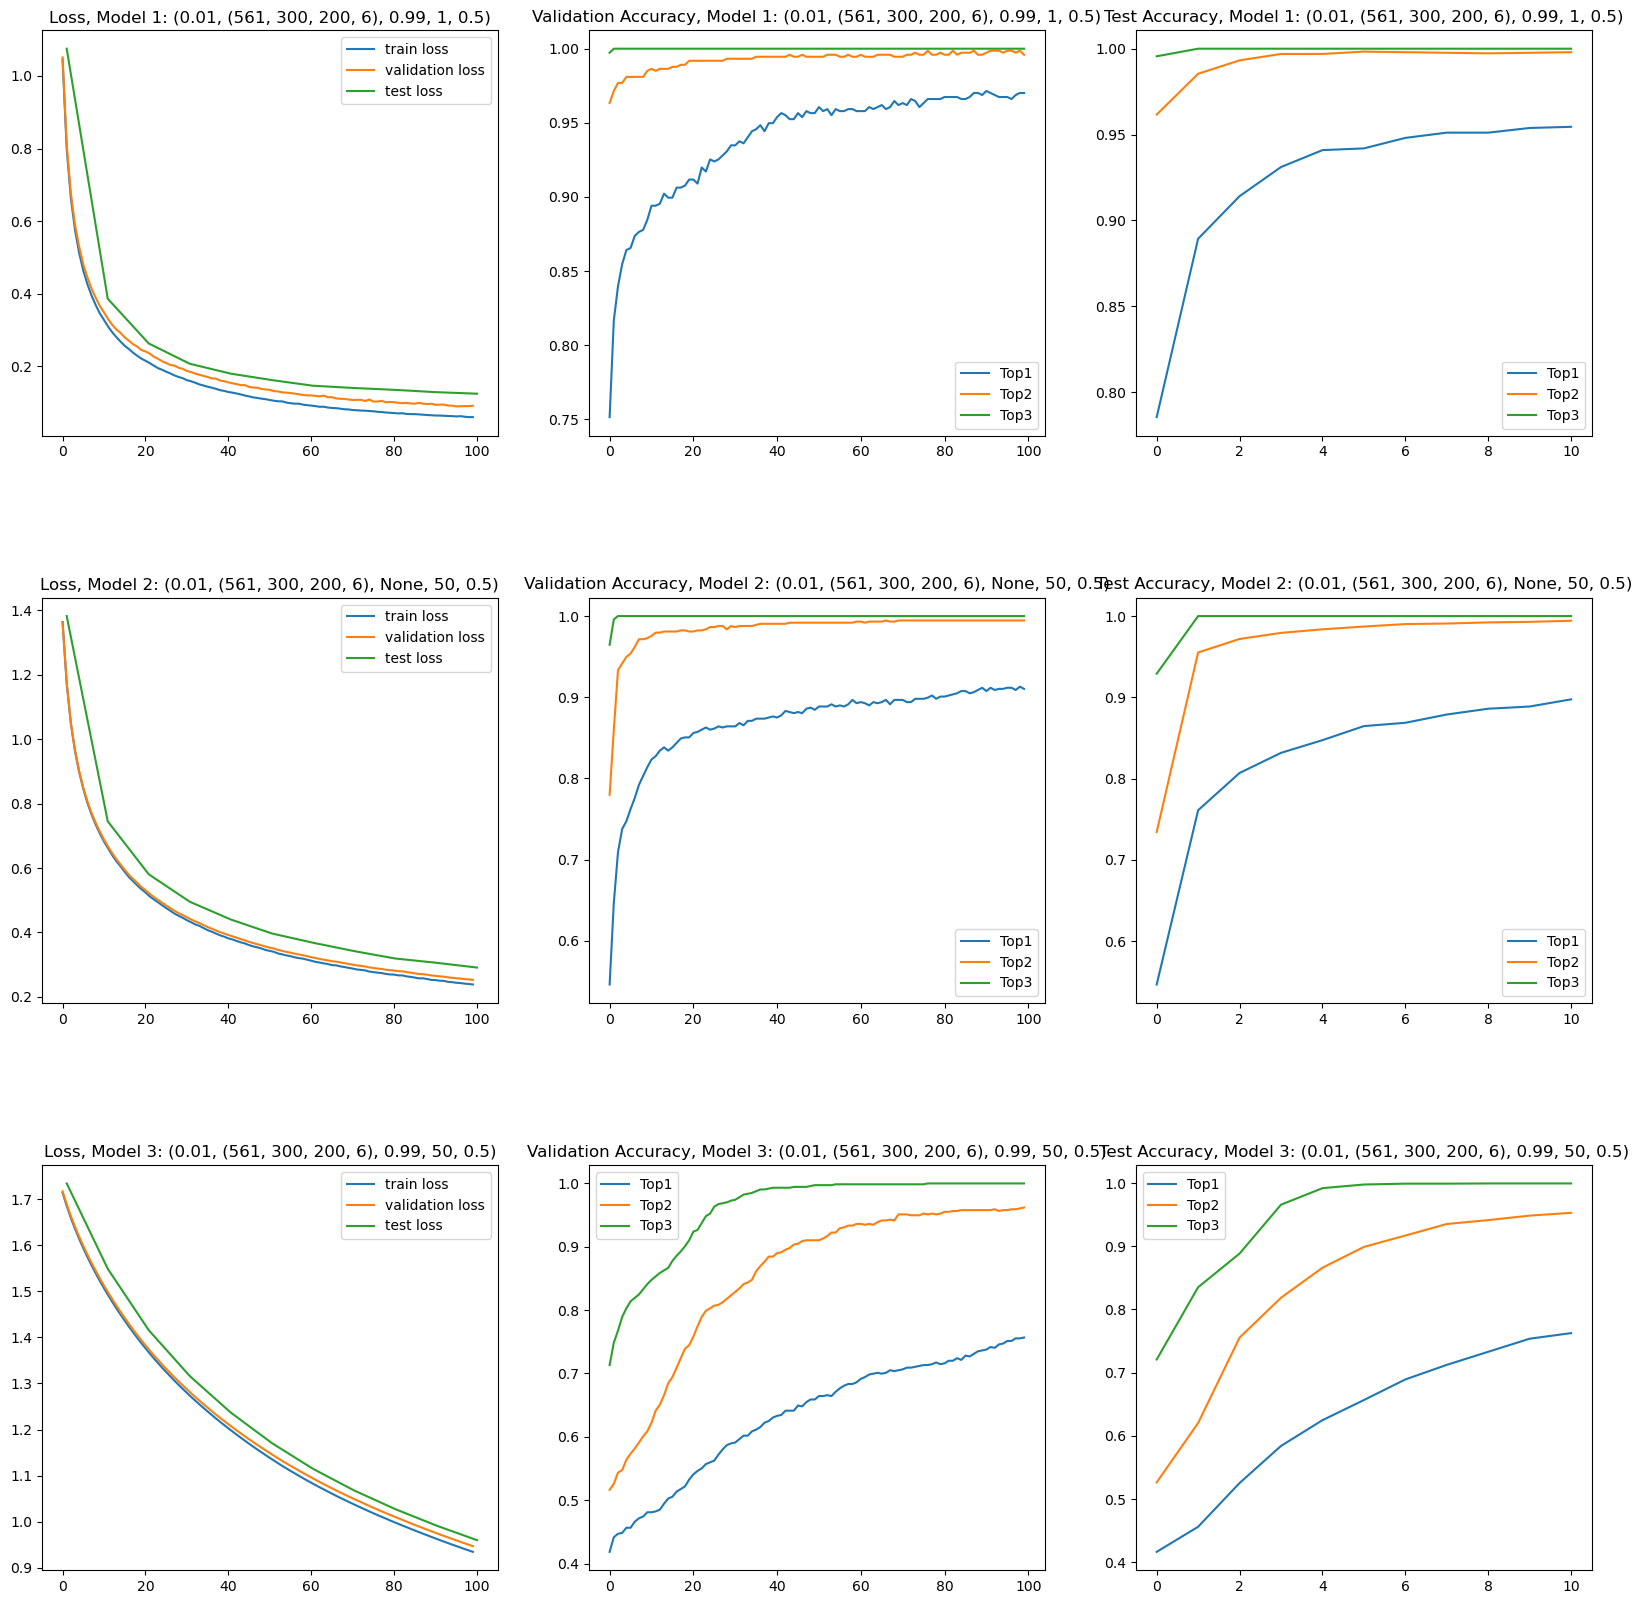

In [154]:
# plot the training, test and validation loss on the 1st column
# plot the validation accuracies on the 2nd column
# plot the test accuracies on the 3rd column
fig, ax = plt.subplots(3, 3, figsize = (20, 20))

for i, key in enumerate(dropout_models.keys()):
    # plot the losses on the first column
    ax[i, 0].plot(range(len(dropout_models[key].train_loss)), dropout_models[key].train_loss, label = "train loss")
    ax[i, 0].plot(range(len(dropout_models[key].train_loss)), dropout_models[key].val_loss, label = "validation loss")
    ax[i, 0].plot(np.linspace(1, len(dropout_models[key].train_loss), (len(dropout_models[key].train_loss)//10) + 1), dropout_models[key].test_loss, label = "test loss")
    ax[i, 0].set_title(f"Loss, Model {i+1}: {key}")
    ax[i, 0].legend()
    # plot the validation accuracies on the second column
    ax[i, 1].plot(range(len(dropout_models[key].train_loss)), [acc[0] for acc in dropout_models[key].val_accuracy], label = "Top1")
    ax[i, 1].plot(range(len(dropout_models[key].train_loss)), [acc[1] for acc in dropout_models[key].val_accuracy], label = "Top2")
    ax[i, 1].plot(range(len(dropout_models[key].train_loss)), [acc[2] for acc in dropout_models[key].val_accuracy], label = "Top3")
    ax[i, 1].set_title(f"Validation Accuracy, Model {i+1}: {key}")
    ax[i, 1].legend()
    # plot the test accuracies
    ax[i, 2].plot( [acc[0] for acc in dropout_models[key].test_accuracy], label = "Top1")
    ax[i, 2].plot( [acc[1] for acc in dropout_models[key].test_accuracy], label = "Top2")
    ax[i, 2].plot( [acc[2] for acc in dropout_models[key].test_accuracy], label = "Top3")
    ax[i, 2].set_title(f"Test Accuracy, Model {i+1}: {key}")
    ax[i, 2].legend()
    
plt.subplots_adjust(hspace=0.4)


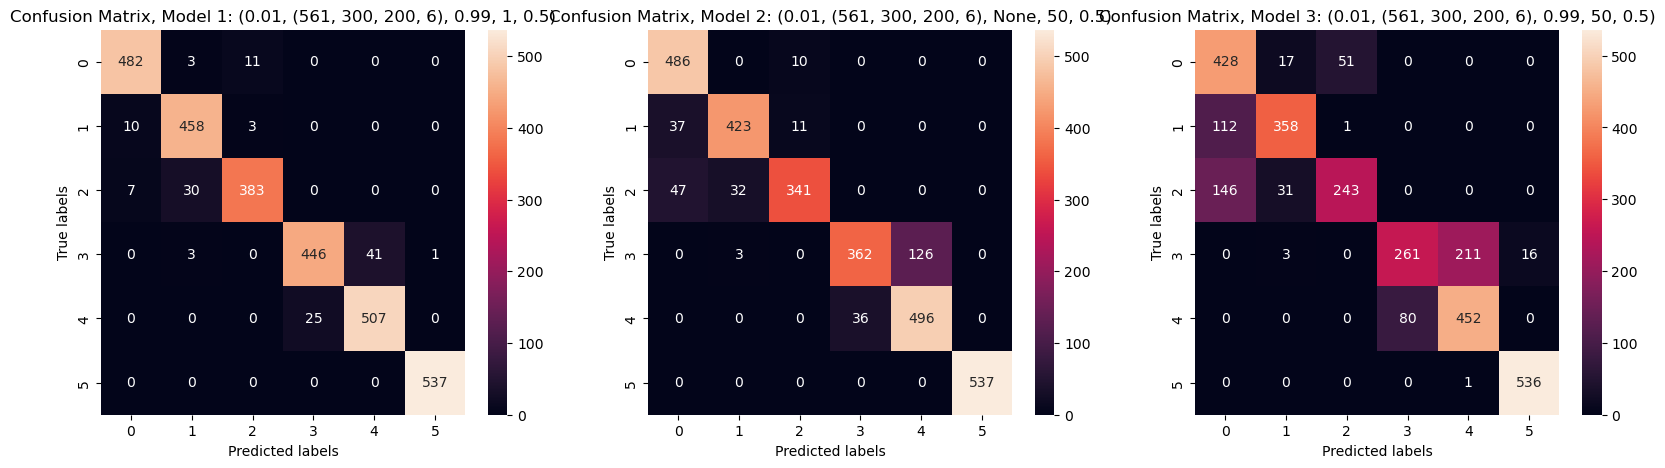

In [179]:
# generate and plot confusion matrices for the 3 models
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
for i, key in enumerate(dropout_models.keys()):
    Y_hat = dropout_models[key].forwardprop(X_test, predict=True)
    Y_hat = np.argmax(Y_hat, axis = 0, keepdims=True)
    Y_true = np.argmax(Y_test, axis = 0, keepdims=True)
    cm = confusion_matrix(Y_true[0], Y_hat[0])
    sns.heatmap(cm, annot=True, ax = ax[i], fmt='g')
    ax[i].set_title(f"Confusion Matrix, Model {i+1}: {key}")
    ax[i].set_xlabel("Predicted labels")
    ax[i].set_ylabel("True labels")
plt.subplots_adjust(hspace=0.4)